## **Scenario**

Imagine you are working for a news aggregator platform that collects articles from various sources. To improve the user experience, the platform wants to automatically categorize these articles into relevant topics. This categorization will help users discover articles of interest more efficiently.

In [1]:
import nltk
nltk.download('stopwords')

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darylroberts/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#Building the Stopwords list
STOPWORDS = set(stopwords.words('english'))

In [4]:
#Defining Hyperparameters
vocab_size = 5000
embedding_dim = 64
max_length = 200
padding_type = 'post'
trunc_type = 'post'
oov_tok = 'OOV'
training_portion = 0.8

In [5]:
#Process the articles and labels into 2 seperate lists
articles = []
labels = []
with open('bbc-text.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader)
    for row in csv_reader:
        label = row[0]
        article = ' '.join([word.lower() for word in row[1].split() if word.lower() not in STOPWORDS])
        labels.append(label)
        articles.append(article)

In [8]:
print(len(articles))
print(len(labels))

2225
2225


In [7]:
#Show what the csv looks like:
import pandas as pd
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [9]:
#Split data into training and validation
train_size = int(len(articles) * training_portion)
train_articles = articles[:train_size]
train_labels = labels[:train_size]
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]
print(train_size)

1780


In [10]:
#Show all label options
unique = list(set(train_labels))
print(unique)

['sport', 'business', 'tech', 'politics', 'entertainment']


In [11]:
#Verify the length of each dataset
print(f'Train articles: {len(train_articles)}')
print(f'Train labels: {len(train_labels)}')
print(f'Validation articles: {len(validation_articles)}')
print(f'Validation labels: {len(validation_labels)}')

Train articles: 1780
Train labels: 1780
Validation articles: 445
Validation labels: 445


In [12]:
#Initialize the tokenizer and Assign a word index
#(Show the first 10 items of the word index to verify it was done correctly)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
for word, index in list(word_index.items())[:10]:
    print(f'{word}: {index}')

OOV: 1
said: 2
mr: 3
would: 4
year: 5
also: 6
people: 7
new: 8
us: 9
one: 10


In [13]:
#Turn the articles into sequences for the RNN using the Tokenizer
train_sequences = tokenizer.texts_to_sequences(train_articles)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)

In [14]:
#Pad the sequences (this ensures all article sequences are the same size. 
#Add 0's to the end of a sequence that doesnt reach the max length of 200
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
print(validation_padded.shape)
print(train_padded.shape)

(445, 200)
(1780, 200)


In [17]:
#Fit tokenizer to labels for computing purposes
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [18]:
#Create the model architecture (key is the embedding and bidirectional LSTM layers)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model.add(tf.keras.layers.Dense(embedding_dim, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394694 (1.51 MB)
Trainable params: 394694 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
#Train the model!
history = model.fit(train_padded, training_label_seq, epochs=10, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 4s - loss: 1.5417 - accuracy: 0.3034 - val_loss: 1.3685 - val_accuracy: 0.3236 - 4s/epoch - 70ms/step
Epoch 2/10
56/56 - 3s - loss: 0.9907 - accuracy: 0.6376 - val_loss: 0.6520 - val_accuracy: 0.8180 - 3s/epoch - 48ms/step
Epoch 3/10
56/56 - 3s - loss: 0.6099 - accuracy: 0.7961 - val_loss: 0.5441 - val_accuracy: 0.7596 - 3s/epoch - 49ms/step
Epoch 4/10
56/56 - 3s - loss: 0.2632 - accuracy: 0.9096 - val_loss: 0.5945 - val_accuracy: 0.8315 - 3s/epoch - 49ms/step
Epoch 5/10
56/56 - 3s - loss: 0.1071 - accuracy: 0.9646 - val_loss: 0.3634 - val_accuracy: 0.8899 - 3s/epoch - 49ms/step
Epoch 6/10
56/56 - 3s - loss: 0.0548 - accuracy: 0.9860 - val_loss: 0.4960 - val_accuracy: 0.8652 - 3s/epoch - 49ms/step
Epoch 7/10
56/56 - 3s - loss: 0.0564 - accuracy: 0.9904 - val_loss: 0.2840 - val_accuracy: 0.9258 - 3s/epoch - 49ms/step
Epoch 8/10
56/56 - 3s - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.3077 - val_accuracy: 0.9191 - 3s/epoch - 49ms/step
Epoch 9/10
56/56 - 3s - loss: 0.

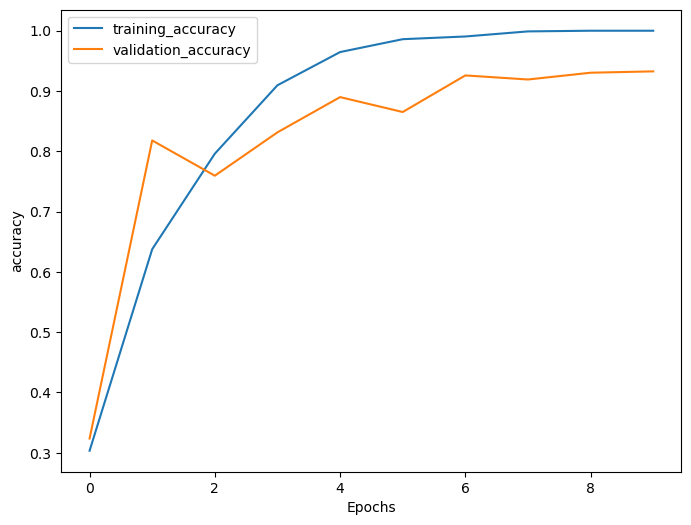

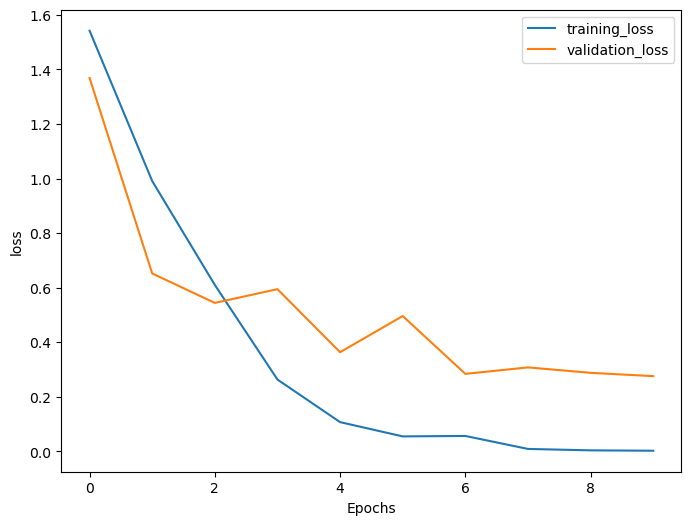

In [22]:
#Plot the graphs showing loss and accuracy over time
def plot_graphs(history, string):
    plt.figure(figsize=(8,6))
    plt.plot(history.history[string])
    plt.plot(history.history[f'val_{string}'])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([f'training_{string}', f'validation_{string}'])
    plt.show()
    
plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')